In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import Libraries.dataloader as dl
from torchviz import make_dot
import random


import segmentation_models_pytorch as smp
from Libraries.dataloader import DataLoader as DL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(np.uint8(color_im))
    depth_raw = o3d.geometry.Image(np.float32(depth_im))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def CreateAxisCloud(depth_im):
    depth_raw  = o3d.geometry.Image(np.float32(depth_im/1)) # Converts depth data into image format
    PointCloud = o3d.geometry.PointCloud.create_from_depth_image(depth_raw,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    # PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,1,0]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [3]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

In [4]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()
X_test, y_test = dl.load(DATASET_ROOTDIR, 'files_Test/data_Test.csv','files_Test/axis', 'S')

In [5]:
# from Libraries.dataloader import DataLoader as DL

# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
# dl = DL()

# X, y = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'files/axis', 'S')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [6]:
# X_train, X_validation, y_train, y_validation = train_test_split(RGBD_in, axis_out, test_size=0.2)

# X_train_aug = X_train.clone()
# for i in range(X_train_aug.shape[0]):
#      X_train_aug[i] = DataAug(X_train_aug[i])
        
# y_train = torch.cat((y_train, y_train),axis=0)
# X_train = torch.cat((X_train, X_train_aug),axis=0)

In [7]:
test_set = TensorDataset(X_test, y_test)
loader_args = dict(batch_size=3, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
test_loader = DataLoader(test_set,shuffle=False, **loader_args)

# Loading Models

In [8]:
device='cuda'
# # # 
Model = smp.Unet(in_channels=3, classes=1,encoder_weights=None,encoder_name='timm-resnest50d').to(device)
Model.load_state_dict(torch.load('Modele/Big_UN1_60Epoch.pt'))
Model.eval()
# # #
ModelCutter = smp.Unet(in_channels=4, classes=1, encoder_weights=None, encoder_name='timm-resnest50d').to(device)
ModelCutter.load_state_dict(torch.load('Modele/Big_UN2-60E.pt'))
ModelCutter.eval()
# # #


Unet(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [9]:
inv_resize = transforms.Resize([480,640], interpolation=transforms.InterpolationMode.NEAREST)

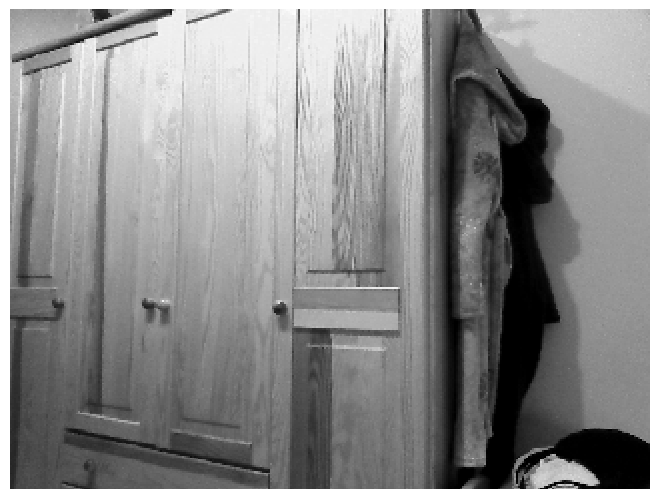

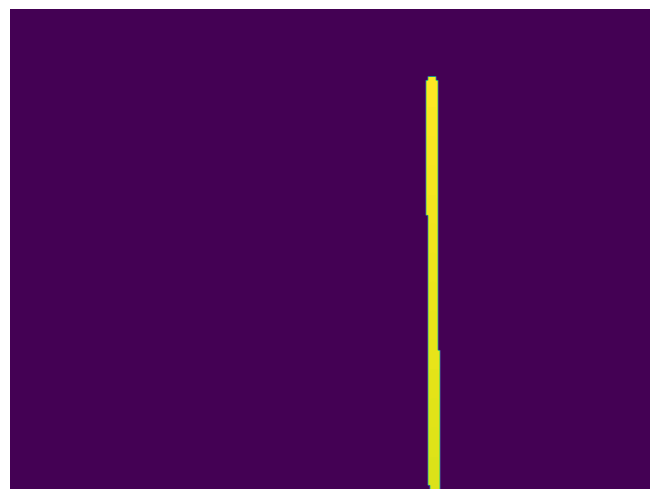

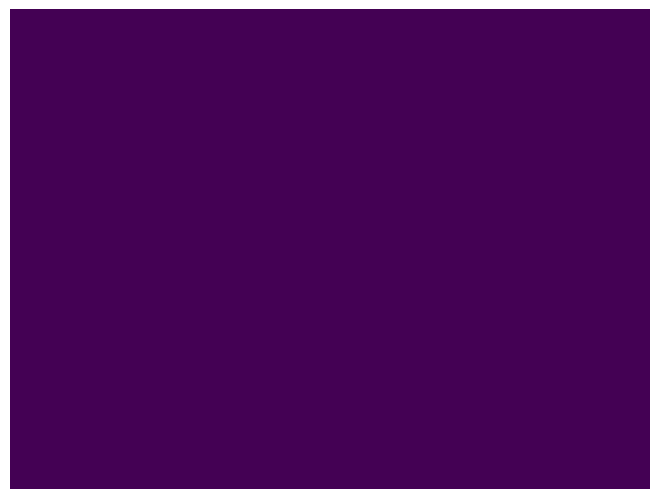

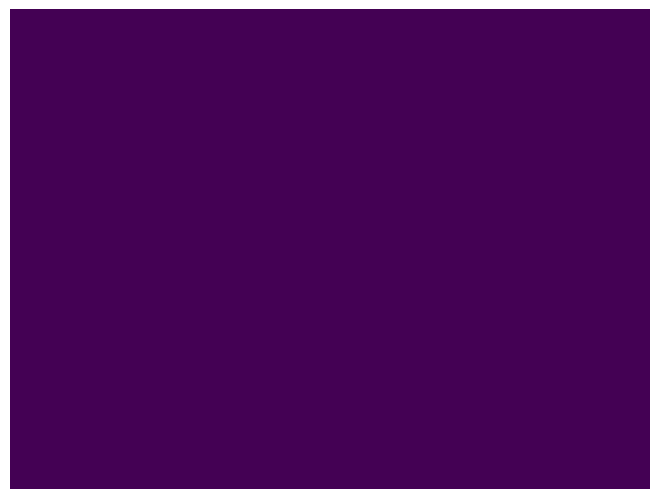

In [18]:
# aaa
Model.eval()
ModelCutter.eval()

num = 32
One_photo_x = X_test[num].reshape(1,
                                      X_test[num].shape[0],
                                      X_test[num].shape[1],
                                      X_test[num].shape[2]
                                     ).to(device)

One_photo_y = y_test[num].reshape(1,
                                      y_test[num].shape[0],
                                      y_test[num].shape[1],
                                      y_test[num].shape[2]
                                     ).to(device)

with torch.no_grad():
    seg2D = Model(One_photo_x)
    seg2D = F.threshold(seg2D, 1, 0)
    
    imag = torch.cat((One_photo_x, seg2D), axis=1)
    
    seg3D = ModelCutter(imag)
    seg3D = F.threshold(seg3D, 1, 0)

images_buff = inv_resize(One_photo_x[0])
RGB_buff = images_buff[0].cpu().numpy()*255
RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

DEPTH_buff = images_buff[1].cpu().numpy()*5500
trueAxis_buff = inv_resize(seg2D[0]).cpu().detach().numpy().transpose(1,2,0)
predAxis_buff = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)

#             NEW_DEPTH = DEPTH_buffq

def SaveFig(input, path, cmap=None):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(input, aspect='auto',cmap=cmap)
    plt.show()
#     fig.savefig(path, format='png')

SaveFig(images_buff[0].cpu().numpy(), 'Images/gray1.png', cmap='gray')
# SaveFig(images_buff[1].cpu().numpy(), 'Images/dep1.png')
# SaveFig(images_buff[2].cpu().numpy(), 'Images/dep12.png')
SaveFig(One_photo_y[0].cpu().detach().numpy().transpose(1,2,0), 'Images/seg1.png')
SaveFig(seg2D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/seg1.png')
SaveFig(seg3D[0].cpu().detach().numpy().transpose(1,2,0), 'Images/test_seg.npy')
# np.save('Images/test_seg.npy', seg3D[0].cpu().detach().numpy().transpose(1,2,0))

AttributeError: 'NoneType' object has no attribute 'predict'

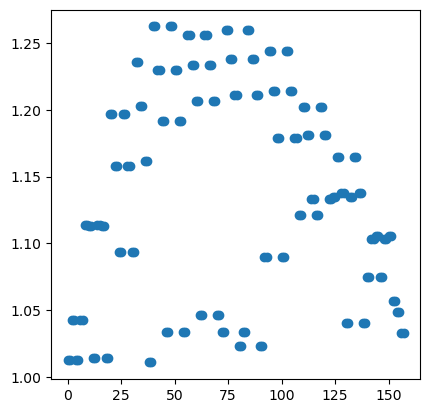

In [15]:
from Libraries import RANSAC


regressor = RANSAC.RANSAC(model=RANSAC.LinearRegressor(), 
                          loss=RANSAC.square_error_loss, 
                          metric=RANSAC.mean_square_error, )

NotFlatPred = inv_resize(seg3D[0]).cpu().detach().numpy().transpose(1,2,0)
FlatPred = NotFlatPred.flatten()
FlatPred = FlatPred[np.nonzero(FlatPred)]

X = np.arange(FlatPred.shape[0])
X = X.reshape(-1,1)
y = FlatPred.reshape(-1,1)
regressor.fit(X, y)

import matplotlib.pyplot as plt
# plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(1, 1)
ax.set_box_aspect(1)

plt.scatter(X, y)

line = np.linspace(0, X.shape[0], num=X.shape[0]).reshape(-1, 1)

# test_complete = test_complete[np.nonzero(test_complete)].flatten().reshape(-1, 1)
NotFlatPred[np.nonzero(NotFlatPred)] = regressor.predict(line).reshape(1, -1)

plt.plot(line, regressor.predict(line), c="r")
# plt.grid()
plt.xlabel('Numer próbki')
plt.ylabel('Wartość obrazu głębi')
plt.legend(['Regresja RANSAC', 'Próbki głębi'] )

# plt.savefig('Images/RANSACprzyklad_1.eps', format='eps')

plt.figure()
plt.scatter(X, y)
plt.show()


PC_object = CreatePointCloud(RGB_buff, DEPTH_buff)
PC_predAxis = CreateAxisCloud(One_photo_y.cpu().detach().numpy().reshape(-1,1))

o3d.visualization.draw_geometries([PC_object,PC_predAxis])